In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv("predictive_maintenance_dataset.csv")

# Overview of the dataset
print("Shape of dataset:", df.shape)
print("\nColumn Types:\n", df.dtypes)
df.head()


Shape of dataset: (124494, 12)

Column Types:
 date       object
device     object
failure     int64
metric1     int64
metric2     int64
metric3     int64
metric4     int64
metric5     int64
metric6     int64
metric7     int64
metric8     int64
metric9     int64
dtype: object


,date,device,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9
0,1/1/2015,S1F01085,0,215630672,55,0,52,6,407438,0,0,7
1,1/1/2015,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,1/1/2015,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
3,1/1/2015,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
4,1/1/2015,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3


Missing values:
 date       0
device     0
failure    0
metric1    0
metric2    0
metric3    0
metric4    0
metric5    0
metric6    0
metric7    0
metric8    0
metric9    0
dtype: int64


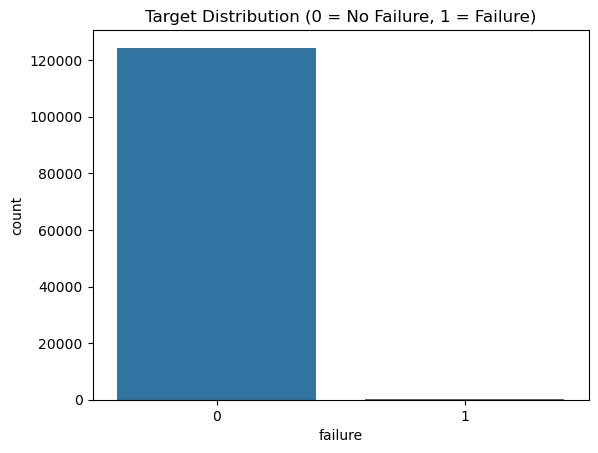

In [2]:
# Check for missing values
print("Missing values:\n", df.isnull().sum())

# Target distribution
sns.countplot(x='failure', data=df)
plt.title("Target Distribution (0 = No Failure, 1 = Failure)")
plt.show()


In [3]:
# Entropy and Gini

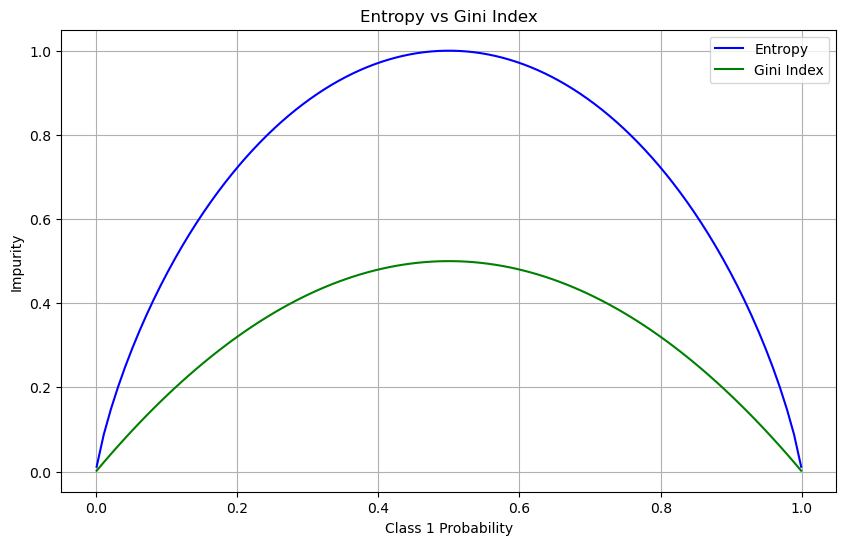

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Class probabilities from 0 to 1
p = np.linspace(0.001, 0.999, 100)

# Binary classification (p and 1-p)
entropy = -p * np.log2(p) - (1 - p) * np.log2(1 - p)
gini = 1 - (p ** 2 + (1 - p) ** 2)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(p, entropy, label='Entropy', color='blue')
plt.plot(p, gini, label='Gini Index', color='green')
plt.title('Entropy vs Gini Index')
plt.xlabel('Class 1 Probability')
plt.ylabel('Impurity')
plt.legend()
plt.grid(True)
plt.show()


In [5]:
from collections import Counter

def gini_index(groups, classes):
    """Calculate Gini index for a split (optimized version)."""
    n_instances = float(sum(len(group) for group in groups))
    gini = 0.0

    for group in groups:
        size = float(len(group))
        if size == 0:
            continue

        # Count once instead of calling .count() repeatedly
        label_counts = Counter(row[-1] for row in group)
        score = sum((label_counts[class_val] / size) ** 2 for class_val in classes)

        gini += (1.0 - score) * (size / n_instances)

    return gini

def test_split(index, value, dataset):
    """Split dataset based on a feature index and feature value."""
    left, right = [], []
    for row in dataset:
        if row[index] < value:
            left.append(row)
        else:
            right.append(row)
    return left, right


In [6]:
def get_split(dataset, num_features=None, num_thresholds=10):
    """Select the best split point for a dataset (optimized)."""
    class_values = list(set(row[-1] for row in dataset))
    best_index, best_value, best_score, best_groups = None, None, float('inf'), None

    feature_indices = list(range(len(dataset[0]) - 1))
    if num_features:
        np.random.shuffle(feature_indices)
        feature_indices = feature_indices[:num_features]

    for index in feature_indices:
        values = [row[index] for row in dataset]
        thresholds = np.linspace(min(values), max(values), num_thresholds)
        for value in thresholds:
            groups = test_split(index, value, dataset)
            gini = gini_index(groups, class_values)
            if gini < best_score:
                best_index, best_value, best_score, best_groups = index, value, gini, groups
    return {'index': best_index, 'value': best_value, 'groups': best_groups}



In [7]:
def to_terminal(group):
    """Create a terminal node value (majority class)."""
    outcomes = [row[-1] for row in group]
    return max(set(outcomes), key=outcomes.count)

def split(node, max_depth, min_size, depth):
    """Create child splits for a node or make terminal."""
    left, right = node['groups']
    del(node['groups'])
    
    # No split
    if not left or not right:
        node['left'] = node['right'] = to_terminal(left + right)
        return

    # Max depth
    if depth >= max_depth:
        node['left'], node['right'] = to_terminal(left), to_terminal(right)
        return

    # Left child
    if len(left) <= min_size:
        node['left'] = to_terminal(left)
    else:
        node['left'] = get_split(left)
        split(node['left'], max_depth, min_size, depth + 1)

    # Right child
    if len(right) <= min_size:
        node['right'] = to_terminal(right)
    else:
        node['right'] = get_split(right)
        split(node['right'], max_depth, min_size, depth + 1)



def build_tree(train, max_depth, min_size):
    """Build a decision tree."""
    # Try 3 random features and 10 thresholds per feature
    root = get_split(train, num_features=3, num_thresholds=10)

    split(root, max_depth, min_size, 1)
    return root


In [8]:
def predict(node, row):
    """Make a prediction with a decision tree."""
    if row[node['index']] < node['value']:
        if isinstance(node['left'], dict):
            return predict(node['left'], row)
        else:
            return node['left']
    else:
        if isinstance(node['right'], dict):
            return predict(node['right'], row)
        else:
            return node['right']


In [9]:
def decision_tree(train, test, max_depth, min_size):
    """Train and test a decision tree."""
    tree = build_tree(train, max_depth, min_size)
    predictions = [predict(tree, row) for row in test]
    return predictions


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Copy the original dataframe
data = df.copy()

# Drop ID column if exists
if 'id' in data.columns:
    data.drop(columns=['id'], inplace=True)

# Encode target and categorical columns
label_encoders = {}
for col in data.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

# Encode the target as binary (failure column)
target = 'failure'
data[target] = data[target].astype(int)

# Convert DataFrame to list format for our custom implementation
dataset = data.values.tolist()

# Split manually
train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)


In [11]:
# Use custom decision tree
max_depth = 10
min_size = 10

# Predict on test set
predictions = decision_tree(train_data, test_data, max_depth, min_size)

# Actual values
actual = [row[-1] for row in test_data]

# Accuracy
correct = sum(1 for i in range(len(actual)) if actual[i] == predictions[i])
accuracy = correct / len(actual) * 100
print(f"Accuracy of custom Decision Tree: {accuracy:.2f}%")


Accuracy of custom Decision Tree: 83.24%


In [12]:
# Random Forest

In [13]:
import random

def subsample(dataset, ratio):
    """Create a random subsample from the dataset with replacement."""
    sample = []
    n_sample = round(len(dataset) * ratio)
    while len(sample) < n_sample:
        index = random.randrange(len(dataset))
        sample.append(dataset[index])
    return sample


In [14]:
def get_split_rf(dataset, n_features):
    """Get best split with random feature selection for Random Forest."""
    class_values = list(set(row[-1] for row in dataset))
    features = []
    
    while len(features) < n_features:
        index = random.randrange(len(dataset[0]) - 1)
        if index not in features:
            features.append(index)

    best_index, best_value, best_score, best_groups = 999, 999, 999, None
    
    for index in features:
        for row in dataset:
            groups = test_split(index, row[index], dataset)
            gini = gini_index(groups, class_values)
            if gini < best_score:
                best_index, best_value, best_score, best_groups = index, row[index], gini, groups
                
    return {'index': best_index, 'value': best_value, 'groups': best_groups}


In [15]:
def split_rf(node, max_depth, min_size, depth, n_features):
    left, right = node['groups']
    del(node['groups'])

    if not left or not right:
        node['left'] = node['right'] = to_terminal(left + right)
        return

    if depth >= max_depth:
        node['left'], node['right'] = to_terminal(left), to_terminal(right)
        return

    if len(left) <= min_size:
        node['left'] = to_terminal(left)
    else:
        node['left'] = get_split_rf(left, n_features)
        split_rf(node['left'], max_depth, min_size, depth + 1, n_features)

    if len(right) <= min_size:
        node['right'] = to_terminal(right)
    else:
        node['right'] = get_split_rf(right, n_features)
        split_rf(node['right'], max_depth, min_size, depth + 1, n_features)

def build_tree_rf(train, max_depth, min_size, n_features):
    root = get_split_rf(train, n_features)
    split_rf(root, max_depth, min_size, 1, n_features)
    return root


In [16]:
def random_forest(train, test, max_depth, min_size, sample_ratio, n_trees, n_features):
    """Train multiple trees and vote on the prediction."""
    trees = []
    for _ in range(n_trees):
        sample = subsample(train, sample_ratio)
        tree = build_tree_rf(sample, max_depth, min_size, n_features)
        trees.append(tree)

    # Make predictions for each tree and vote
    predictions = []
    for row in test:
        votes = [predict(tree, row) for tree in trees]
        prediction = max(set(votes), key=votes.count)
        predictions.append(prediction)
    
    return predictions


In [ ]:
# Parameters
n_trees = 10
max_depth = 8
min_size = 10
sample_ratio = 0.8
n_features = int(np.sqrt(len(train_data[0]) - 1))

# Predict
rf_predictions = random_forest(train_data, test_data, max_depth, min_size, sample_ratio, n_trees, n_features)

# Actual values
actual = [row[-1] for row in test_data]

# Accuracy
correct_rf = sum(1 for i in range(len(actual)) if actual[i] == rf_predictions[i])
accuracy_rf = correct_rf / len(actual) * 100
print(f"Accuracy of Random Forest (from scratch): {accuracy_rf:.2f}%")


Accuracy of Random Forest (from scratch): 81.01%
